# Export a PyTorch model to ONNX
* Install the required dependencies.

* Author a simple image classifier model.

* Export the model to ONNX format.

* Save the ONNX model in a file.

* Visualize the ONNX model graph using Netron.

* Execute the ONNX model with ONNX Runtime

* Compare the PyTorch results with the ones from the ONNX Runtime.

## 1. Install the required dependencies


In [27]:
!pip install onnx
!pip install onnxscript


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Author a simple image classifier model


In [28]:
!pip install torch


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 3. Export the model to ONNX format

In [30]:
torch_model = MyModel()
torch_input = torch.randn(1, 1, 32, 32)
onnx_program = torch.onnx.export(torch_model, torch_input, dynamo=True)

W0214 15:11:56.840000 5800 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:66] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `MyModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MyModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


## 4. Save the ONNX model in a file


In [31]:
onnx_program.save("my_image_classifier.onnx")

In [32]:
import onnx
onnx_model = onnx.load("my_image_classifier.onnx")
onnx.checker.check_model(onnx_model)

## 5. Visualize the ONNX model graph using Netron


The web version by opening the following link: https://netron.app/.
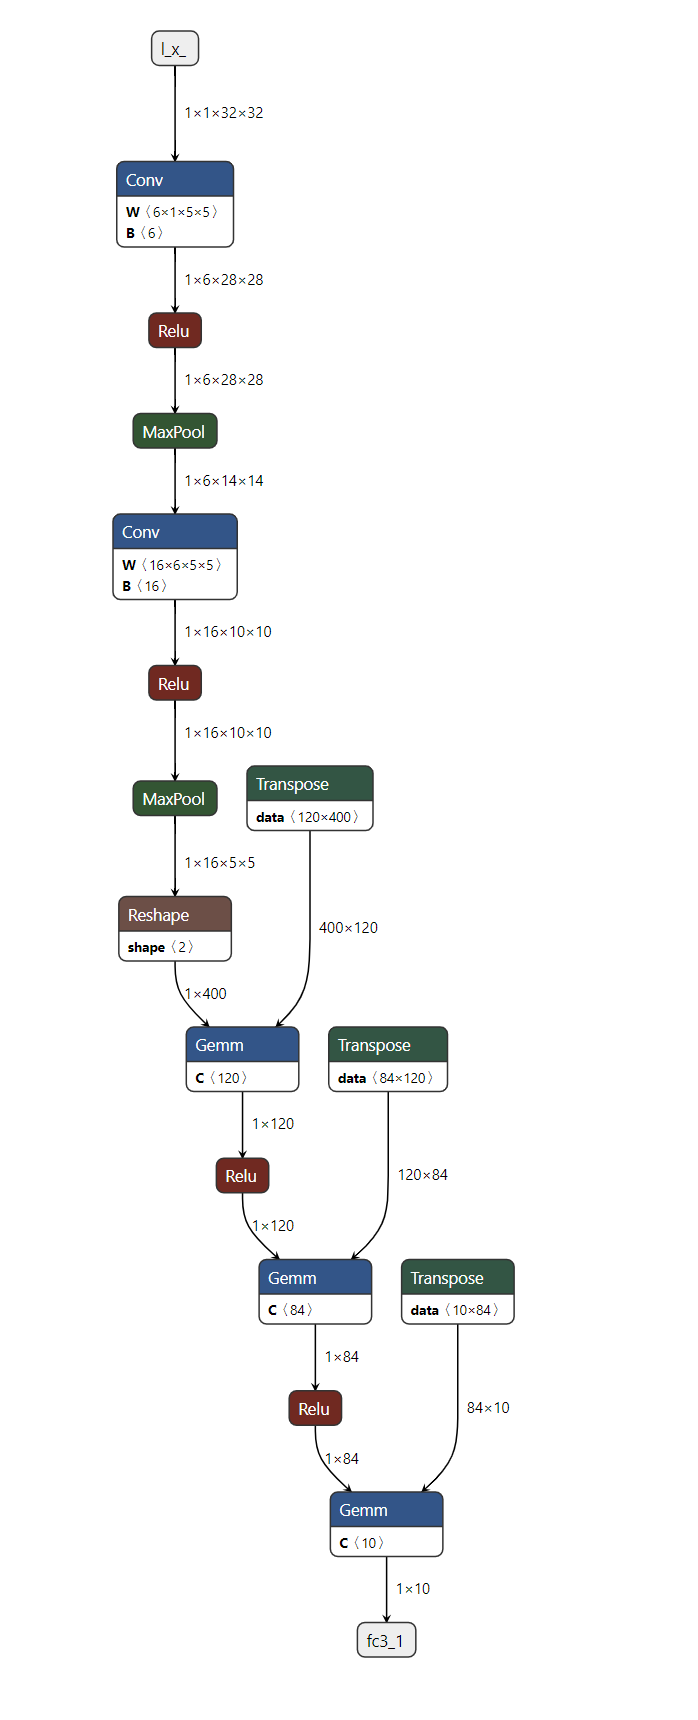

## 6. Execute the ONNX model with ONNX Runtime

In [33]:
!pip install onnxruntime

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.3 MB 960.0 kB/s eta 0:00:12
    --------------------------------------- 0.2/11.3 MB 2.4 MB/s eta 0:00:05
   - -------------------------------------- 0.4/11.3 MB 3.2 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/11.3 MB 4.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/11.3 MB 5.5 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/11.3 MB 4.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.3 MB 7.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.3 MB 7.2 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/11.3 MB 6.2 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.3 MB 6.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.3 MB 7.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.3 MB 6.9 MB/s eta 0:00:02
   -


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./my_image_classifier.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[ 8.1046e-01, -2.0601e-03, -8.9022e-01,  ...,  1.9525e-01,
           -1.0394e-01,  1.2254e+00],
          [ 4.5255e-01,  8.2086e-01, -5.0557e-02,  ...,  9.7235e-01,
            9.3443e-01,  8.4359e-01],
          [ 1.2773e+00, -1.8102e+00,  8.8727e-01,  ...,  2.5163e-01,
           -2.0841e+00,  2.9767e-01],
          ...,
          [ 1.3974e-01, -1.6913e+00, -1.0043e+00,  ..., -5.6040e-01,
            3.4824e-01, -9.2256e-01],
          [ 1.1063e+00, -1.5089e+00,  9.4139e-02,  ..., -1.4528e+00,
           -2.9368e-02, -6.8615e-02],
          [ 1.5171e+00,  4.4895e-01, -4.3027e-01,  ...,  1.4623e-01,
           -1.8646e+00, -2.2324e-01]]]])]


## 7. Compare the PyTorch results with the ones from the ONNX Runtime


In [35]:
torch_outputs = torch_model(torch_input)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [[-0.02523759  0.07604366  0.19816685 -0.11635736 -0.06177334 -0.01760531
   0.10035428  0.00181959  0.0327499   0.14038208]]
